In [17]:
from torchvision import transforms
from datasets import load_dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from PIL import Image 
from scipy.ndimage import zoom
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
#from sklearn.manifold import MDS
from numpy import linalg as la
from datetime import datetime
import pickle
from tqdm import tqdm
import time
from scipy.spatial.distance import pdist, squareform

In [2]:
import ot

2025-11-20 09:36:31.062350: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-20 09:36:31.899942: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


#### Defining required functions

##### Wasserstein Distance matrix computation using ot.sinkhorn2

In [40]:
# Compute Wasserstein distance between two point clouds
def compute_wasserstein_distance(pc1, pc2, reg=1):
    """
    Takes in two pointclouds pc1 and pc2, i.e., pc1 = [x1,y1,w1;...;xp,yp,wp], etc. and computes the Wasserstein-2 distance
    between pc1 and pc2.
    """
    # Reshaping and stripping out (x,y) locations (Upts, Vpts) and weights (Uwts, Vwts)
    pc1pts = np.ascontiguousarray(pc1[:,0:2])
    pc2pts = np.ascontiguousarray(pc2[:,0:2])
    pc1wts = np.ascontiguousarray(pc1[:,2])
    pc2wts = np.ascontiguousarray(pc2[:,2])
    pc1wts = pc1wts/np.sum(pc1wts) # normalize to make a probability
    pc2wts = pc2wts/np.sum(pc2wts) # normalize to make a probability  
    M = ot.dist(pc1pts, pc2pts, metric = 'sqeuclidean')  # Compute squared euclidean distance on the pointcloud points
    W = ot.sinkhorn2(pc1wts,pc2wts, M, reg=reg) # Compute exact squared Wasserstein-2 distance between U and V  
    # -------------------------------------Debug----------------------------------------- #
    # print(f"Mean: pc1pts:{np.mean(pc1pts):.3f} | pc2pts:{np.mean(pc2pts):.3f} | \
    # pc1wts:{np.mean(pc1wts):.3f} | pc2wts:{np.mean(pc2wts):.3f} | \      
    # Mean(M):{np.mean(M):.3f} | Median(M):{np.median(M):.3f} | W2-Distance: {W:.2f}")    #
    # -------------------------------------Debug----------------------------------------- #
    return W

def Wasserstein_Matrix(image_list, reg=1, squared=True):
    """
    The function compute the (squared if squared=True) Wasserstein Distance Matrix between N images
    image_list: python list of pointcloud representations
    """
    N = len(image_list) #number of images
    distance = np.zeros((N,N))  # initialize the distance matrix
    tic = time.perf_counter()
    for i in range(N):
        for j in range(i+1,N):
            if squared==True:
                distance[i,j] = compute_wasserstein_distance(image_list[i], image_list[j], reg=reg)
                # print(f"Row:{i} | Column:{j} | Distance:{distance[i,j]:.2f}")  #------Debug 
            else:
                distance[i,j] = compute_wasserstein_distance(image_list[i], image_list[j], reg=reg)**.5
    distance += distance.T  
    toc = time.perf_counter()
    total_time = (toc - tic)/60
    print(f"Computed {distance.shape}-distance matrix in {total_time:.2f} mins")
    return distance

##### Existing CCS algorithm (column only version)

This version of CCS sampling assumes a pre-computed distance matrix which is passed as input and applies sampling on selected columns only.

In [56]:
# Helper function
def set_default_params_CCS(params):
    """Set default parameters for CCS if missing."""
    defaults = {'p': 0.2, 'delta': 0.3}
    for k, v in defaults.items():
        params.setdefault(k, v)
    return params

# CCS on pre-computed distance matrix
def CCS(X, params_CCS, rng=None):
    """Cross-Concentrated Sampling (generic version)."""
    params_CCS = set_default_params_CCS(params_CCS)
    rng = np.random.default_rng(rng)
    p = params_CCS['p']
    delta = params_CCS['delta']
    m, n = X.shape
    num_c = round(n * delta)
    J_ccs = rng.choice(n, num_c, replace=False)
    C = X[:, J_ccs]
    ubc = min(num_c * m, int(np.ceil(p * num_c * m)))
    C_obs_ind = rng.choice(num_c * m, ubc, replace=False)
    C_Obs = np.zeros((m, num_c), dtype=X.dtype)
    C_Obs.flat[C_obs_ind] = C.flat[C_obs_ind]
    X_Omega_ccs = np.zeros((m, n), dtype=X.dtype)
    X_Omega_ccs[:, J_ccs] = C_Obs
    selected_indices = np.argwhere(X_Omega_ccs != 0)
    selected_indices = np.unique(selected_indices, axis=0)
    return X_Omega_ccs, J_ccs, selected_indices, C_obs_ind

##### Column-CCS: Partial distance matrix computation

This modified Column-CCS sampling alogirthm takes a point-cloud array as input and computes the partial distance matrix based on selected p and delta values.

In [55]:
# Default setup
def set_default_params_CCS(params):
    """Set default parameters for CCS if missing."""
    defaults = {'p': 0.2, 'delta': 0.3}
    for k, v in defaults.items():
        params.setdefault(k, v)
    return params

#---------Main function---------------#
def Wass_Matrix_CCS_Col(image_list, params_CCS, squared=True, rng=None, reg=1):
    """
    Compute a sparse Wasserstein Distance Matrix using CCS sampling, only from selected columns.   
    Parameters:
    - image_list: List of point clouds ([x, y, w] arrays).
    - p: Sampling probability within selected columns (default: 0.3).
    - delta: Fraction of columns to sample (default: 0.2).
    - squared: If True, compute squared Wasserstein distance; else, take square root.
    Returns:
    - distance: Sparse NxN NumPy array with Wasserstein distances.
    - J_ccs: Sampled column indices.
    - sampled_positions: Nx3 NumPy array of [row_idx, col_idx, distance] for sampled positions.
    """
    params_CCS = set_default_params_CCS(params_CCS)
    rng = np.random.default_rng(rng)
    p = params_CCS['p']
    delta = params_CCS['delta']
    N = len(image_list)
    distance = np.zeros((N, N))
    num_c = round(N * delta)
    J_ccs = rng.choice(N, num_c, replace=False)
    ubc = min(num_c * N, int(np.ceil(p * num_c * N)))
    C_obs_ind = rng.choice(num_c * N, ubc, replace=False)
    print(f"Sampling {ubc} column entries out of selected {num_c} columns")

    # Lists to store sampled positions and distances
    row_indices = []
    col_indices = []
    distances = []
    tic = time.perf_counter()

    for idx in C_obs_ind:
        i = idx // num_c
        j = idx % num_c
        j_full = J_ccs[j]
        if i != j_full:
            dist = compute_wasserstein_distance(point_clouds[i], point_clouds[j_full], reg=reg)
            computed_dist = dist if squared else np.sqrt(dist)
            distance[i, j_full] = computed_dist
            # print(f"Row:{i} | Column:{j_full} | Distance:{computed_dist:.2f}")  # -----Debug  
            row_indices.append(i)
            col_indices.append(j_full)
            distances.append(computed_dist)
        else:
            distance[i, j_full] = 0.0
            distance[j_full, i] = 0.0
    
    toc = time.perf_counter()
    total_time = (toc - tic)/60
    computed_entries = np.count_nonzero(distance)
    print(f"Computed {computed_entries}/{N*N} distances ({computed_entries/(N*N)*100:.2f}%) in {total_time:.2f} mins")
    # Combine indices and distances into Nx3 array
    sampled_positions = np.column_stack((row_indices, col_indices, distances))

    return distance, J_ccs, sampled_positions

##### Column only ICURC

In [141]:
def set_default_params_ICURC(s):
    if 'TOL' not in s:
        s['TOL'] = 1e-4
    if 'max_ite' not in s:
        s['max_ite'] = 500
    if 'eta' not in s:
        s['eta'] = [1, 1, 1]
        s['steps_are1'] = True
    elif s['eta'] == [1, 1, 1]:
        s['steps_are1'] = True
    else:
        s['steps_are1'] = False
    return s

def ICURC(X_Omega, J_ccs, r, params_ICURC):
    params_ICURC = set_default_params_ICURC(params_ICURC)
    eta = params_ICURC['eta']
    #print(f'Using stepsize eta_C = {eta[0]:.6f}.')
    #print(f'Using stepsize eta_R = {eta[1]:.6f}.')
    #print(f'Using stepsize eta_U = {eta[2]:.6f}.')
    eta = params_ICURC['eta']
    TOL = params_ICURC['TOL']
    max_ite = params_ICURC['max_ite']
    steps_are1 = params_ICURC['steps_are1']

    Obs_U = X_Omega[np.ix_(J_ccs, J_ccs)]
    Obs_C = X_Omega[:, J_ccs]
    Smp_C = (Obs_C != 0)
    Smp_U = (Obs_U != 0)

    Omega_col = np.where(Smp_C.flatten())[0]
    Omega_U = np.where(Smp_U.flatten())[0]
    L_obs_col_vec = Obs_C.flatten()[Omega_col]
    L_obs_U_vec = Obs_U.flatten()[Omega_U]
    normC_obs = np.linalg.norm(L_obs_col_vec)
    normU_obs = np.linalg.norm(L_obs_U_vec)
    col_norm_sum = normC_obs + normU_obs 

    if col_norm_sum == 0:
        col_norm_sum = 1.0

    U = Obs_U.copy()
    u, s, vh = np.linalg.svd(U, full_matrices=False)
    u = u[:, :r]
    vh = vh[:r, :]
    s = np.diag(s[:r])
    U = u @ s @ vh

    C = Obs_C.copy()

    fct_time = time.time()
    for ICURC_ite in range(1, max_ite + 1):
        ite_time = time.time()

        #R = u @ (u.T @ R)
        C = C @ (vh.T @ vh)

        U_flat = U.flatten()
        C_flat = C.flatten()
        New_Error =  (np.linalg.norm(C_flat[Omega_col] - L_obs_col_vec) +
                     np.linalg.norm(U_flat[Omega_U] - L_obs_U_vec)) / col_norm_sum

        if New_Error < TOL or ICURC_ite == max_ite:
            ICURC_time = time.time() - fct_time

            C_flat = C_flat.copy()
            C_flat[Omega_col] = L_obs_col_vec
            C = C_flat.reshape(C.shape)

            U_flat = U_flat.copy()
            U_flat[Omega_U] = L_obs_U_vec
            U = U_flat.reshape(U.shape)

            u, s, vh = np.linalg.svd(U, full_matrices=False)
            u = u[:, :r]
            vh = vh[:r, :]
            s = np.diag(s[:r])
            U_pinv = vh.T @ np.linalg.pinv(s) @ u.T

            #print(f'ICURC finished in {ICURC_ite} iterations, final error: {New_Error:.2e}, total runtime: {ICURC_time:.2f}s')
            return C, U_pinv, ICURC_time

        if not steps_are1:
            C_flat = C_flat.copy()
            C_flat[Omega_col] = (1 - eta[0]) * C_flat[Omega_col] + eta[0] * L_obs_col_vec
            C = C_flat.reshape(C.shape)

            U_flat = U_flat.copy()
            U_flat[Omega_U] = (1 - eta[2]) * U_flat[Omega_U] + eta[2] * L_obs_U_vec
            U = U_flat.reshape(U.shape)
        else:
            C_flat = C_flat.copy()
            C_flat[Omega_col] = L_obs_col_vec
            C = C_flat.reshape(C.shape)
            U_flat = U_flat.copy()
            U_flat[Omega_U] = L_obs_U_vec
            U = U_flat.reshape(U.shape)

        u, s, vh = np.linalg.svd(U, full_matrices=False)
        u = u[:, :r]
        vh = vh[:r, :]
        s = np.diag(s[:r])
        U = u @ s @ vh

        #print(f'Iteration {ICURC_ite}: error: {New_Error:.2e}, timer: {time.time() - ite_time:.2f}s')

##### Functions for SNR comparison

In [151]:
def compute_snr_db(W_true, W_recon):
    """
    Compute SNR (in dB) between ground truth and reconstructed distance matrices.
    """
    signal = np.linalg.norm(W_true)
    noise = np.linalg.norm(W_true - W_recon)
    if noise <= 0:
        return np.inf
    return 20 * np.log10(signal / noise)

# Store SNR values for various p and delta values
def comapare_CCS_SNR(dist_matrix, pd_values_df, method=1, r=4):
    """
    This function takes in a full distance matrix and applied CCS-ICURC algorithm
    Computes Signal to Noise Ratio for various pre-computed p and delta values
    """  
    tot_n = dist_matrix.shape[0]
    pd_values_df["SNR"] = np.nan
    pd_values_df["RecoveryTime(secs)"] = np.nan
    pd_values_df["CCS_Sample%"] = np.nan
    # Iterate through different p and delta values from DataFrame
    for idx, row in pd_values_df.iterrows():
        params_CCS = {'p': row['p'], 'delta': row['delta']}
        #print(params_CCS)
        params_ICURC = {
        'eta': [1 / params_CCS['p'], 1 / params_CCS['p'], 1 / (2 * params_CCS['p'])],
        'TOL': 1e-4,
        'max_ite': 100
        }
        # Apply column-only CCS on the full distance matrix
        X_Omega_CCS, J_CCS, sampled_positions, C_Obs = CCS(dist_matrix, params_CCS)
        X_Omega_ccs[np.ix_(J_ccs, J_ccs)] = dist_matrix[np.ix_(J_ccs, J_ccs)]
        C, U_pinv, ICURC_time = ICURC(X_Omega_CCS, J_CCS, r, params_ICURC)
        Mout_CURf = C @ U_pinv @ C.T
        np.fill_diagonal(Mout_CURf, 0) 
        ccs_snr = compute_snr_db(dist_matrix, Mout_CURf)  # Compute SNR
        # Assign SNR to the current row
        pd_values_df.at[idx, "SNR"] = round(ccs_snr,4)
        pd_values_df.at[idx, "RecoveryTime(secs)"] = round(ICURC_time,2)
        pd_values_df.at[idx, "CCS_Sample%"] = round((len(sampled_positions)/(tot_n*tot_n)*100),2)
    return pd_values_df

# # Store SNR values for various p and delta values
# def comapare_CCS_SNR2(full_dist_matrix, partial_dist_matrix, sampled_cols, pd_values_df, method=1, r=4):
#     """
#     This function takes in a partial distance matrix and applies ICURC algorithm
#     Computes Signal to Noise Ratio for various pre-computed p and delta values
#     """  
#     tot_n = partial_dist_matrix.shape[0]
#     pd_values_df["SNR"] = np.nan
#     pd_values_df["RecoveryTime(secs)"] = np.nan
#     pd_values_df["CCS_Sample%"] = np.nan
#     # Iterate through different p and delta values from DataFrame
#     for idx, row in pd_values_df.iterrows():
#         params_CCS = {'p': row['p'], 'delta': row['delta']}
#         #print(params_CCS)
#         params_ICURC = {
#         'eta': [1 / params_CCS['p'], 1 / params_CCS['p'], 1 / (2 * params_CCS['p'])],
#         'TOL': 1e-4,
#         'max_ite': 100
#         }
#         # Apply column-only CCS on the full distance matrix
#         #X_Omega_CCS, J_CCS, sampled_positions, C_Obs = CCS(dist_matrix, params_CCS)
#         #X_Omega_ccs[np.ix_(J_ccs, J_ccs)] = dist_matrix[np.ix_(J_ccs, J_ccs)]
#         C, U_pinv, ICURC_time = ICURC(partial_dist_matrix, sampled_cols, r, params_ICURC)
#         Mout_CURf = C @ U_pinv @ C.T
#         np.fill_diagonal(Mout_CURf, 0)
#         ccs_snr = compute_snr_db(full_dist_matrix, Mout_CURf)  # Compute SNR
#         # Assign SNR to the current row
#         pd_values_df.at[idx, "SNR"] = round(ccs_snr,4)
#         pd_values_df.at[idx, "RecoveryTime(secs)"] = round(ICURC_time,2)
#         pd_values_df.at[idx, "CCS_Sample%"] = round((len(sampled_positions)/(tot_n*tot_n)*100),2)
#     return pd_values_df




def show_snr_lineplot(df_input):
    """ Plots only non-zero and non-null SNR values"""
    #df = df_input.loc[df_input['SNR'] > 0]
    #df = df_input.where(df_input['SNR'] > 0).dropna()
    df=df_input.copy()
    # Create a new column for x-axis labels as (p, delta) pairs
    df['p_delta_pair'] = list(zip(df['p'], df['delta'], df['CCS_Sample%']))  # tuple pairs
    # OR as strings if you want nicer labels: "(p, delta)"
    df['p_delta_pair_str'] = df['p_delta_pair'].apply(lambda x: f"({x[0]:.2f}, {x[1]:.2f}, {x[2]:.1f})")

    # Plot
    plt.figure(figsize=(12,6))
    plt.plot(df['p_delta_pair_str'], df['SNR'], marker='o', linestyle='-')
    plt.xticks(rotation=45, ha='right')  # rotate x-axis labels for readability
    plt.xlabel('(p, delta, Sample%)')
    plt.ylabel('SNR (dB)')
    plt.title('SNR for different (p, delta) pairs')
    plt.grid(False)
    plt.tight_layout()
    plt.show()


def rank_snr_lineplot(df_input):
    """ Plots only non-zero and non-null SNR values"""
    #df = df_input.loc[df_input['SNR'] > 0]
    df = df_input.where(df_input['SNR'] > 0).dropna()
    """ Plots all SNR values"""
    #df=df_input.copy()
    # Create a new column for x-axis labels as (p, delta) pairs
    df['p_delta_rank'] = list(zip(df['p'], df['delta'], df['Rank']))  # tuple pairs
    # OR as strings if you want nicer labels: "(p, delta)"
    df['p_delta_pair_str'] = df['p_delta_rank'].apply(lambda x: f"({x[0]:.2f}, {x[1]:.2f}, {x[2]:.1f})")

    # Plot
    plt.figure(figsize=(12,6))
    plt.plot(df['p_delta_pair_str'], df['SNR'], marker='o', color='green', linestyle='-')
    plt.xticks(rotation=90, ha='right')  # rotate x-axis labels for readability
    plt.xlabel('(p, delta, Rank)')
    plt.ylabel('SNR (dB)')
    plt.title('SNR for different (p, delta, rank) pairs')
    plt.grid(False)
    plt.tight_layout()
    plt.show()


def rank_snr_heatmap(df_input, rounded_frac=True):
    """ Plots only non-zero and non-null SNR values"""
    #df = df_input.where(df_input['SNR'] > 0).dropna()
    """ Plots all SNR values"""
    df=df_input.copy()
    # Create a pivot table for heatmap
    if rounded_frac:
        heatmap_data = df.pivot(index='SamplePercentage', columns='Rank', values='SNR')
    else:
        heatmap_data = df.pivot(index='CCS_Sample%', columns='Rank', values='SNR')    
    plt.figure(figsize=(10,6))
    sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap='viridis')
    plt.xlabel('Rank')
    plt.ylabel('Sample Percentage')
    plt.title('SNR Heatmap')
    plt.show()

##### Visualizations

In [25]:
from matplotlib.colors import ListedColormap

def visualize_distance_matrix(
        W_partial,
        title="Wasserstein Distance Matrix",
        highlight_color='lime'):          # any matplotlib colour name / hex
    """
    Heat-map:
      • 0          → black
      • non-zero   → single highlight colour (no gradient)
      • no colour-bar
    Args:
        W_partial: np.ndarray of shape [N, N]
        title:     plot title
        highlight_color: colour for non-zero cells
    """
    plt.figure(figsize=(8, 7))
    # 1. Binary mask
    mask_nonzero = (W_partial != 0).astype(float)   # 1.0 = non-zero, 0.0 = zero
    # 2. Plot zeros → black background
    plt.imshow(np.zeros_like(W_partial),
               cmap='gray', vmin=0, vmax=1, interpolation='nearest')
    # Create a colormap that maps 0 → black and 1 → highlight_color
    cmap = ListedColormap(['black', highlight_color])
    plt.imshow(mask_nonzero, cmap=cmap, vmin=0, vmax=1,
               interpolation='nearest', alpha=1.0)

    plt.title(title, fontsize=14)
    plt.xticks([])
    plt.yticks([])
    plt.box(False)
    plt.xlabel("Image Index")
    plt.ylabel("Image Index")

    plt.tight_layout()
    plt.show()

### Main code

#### Load 1000 point_clouds from local drive

In [3]:
import pickle 

# Specify the path where you want to load the file from
save_path = "/home/axk8440@uta.edu/Documents/CapstoneProject/ResolutionTest/point_clouds_1000_28x28.pkl"

# Load from the file using pickle
with open(save_path, 'rb') as f:
    point_clouds = pickle.load(f)

print("Loaded dictionary from local drive")

Loaded dictionary from local drive


In [20]:
W_dist_matrix = np.load('ImageNet1000_fulldist_matrix_28x28.npy')
W_dist_matrix.shape

(1000, 1000)

#### Compute Full Distance matrix without any sampling

In [ ]:
full_dist_matrix = Wasserstein_Matrix(point_clouds, reg=1, squared=True)

In [43]:
# Define the filename for saving
filename = 'ImageNet1000_fulldistance_matrix_28x28.npy'

# Save the array to the specified file
np.save(filename, full_dist_matrix)

print(f"NumPy array saved to {filename}")

NumPy array saved to ImageNet1000_fulldistance_matrix_28x28.npy


In [44]:
full_dist_matrix.shape

(1000, 1000)

#### Compute partial distance matrix using new Col-CCS algorithm

In [106]:
params_CCS

{'p': 0.76, 'delta': 0.25}

In [86]:
# Run for modified Col_CCS on full dataset
#params_CCS = {'p': 0.26, 'delta': 0.40}
params_CCS = {'p': 0.76, 'delta': 0.25}

X_Omega_ccs, J_ccs, sampled_positions = Wass_Matrix_CCS_Col(point_clouds,
                                                            params_CCS,
                                                            rng=67,
                                                            reg=1,
                                                            squared=True)

print("J_ccs length:", len(J_ccs))
print("Total sampled_positions:\n", len(sampled_positions))

Sampling 190000 column entries out of selected 250 columns
Computed 189807/1000000 distances (18.98%) in 336.35 mins
J_ccs length: 250
Total sampled_positions:
 189807


In [85]:
# filename = "X_Omega_ccs_p26d40.npy"
# np.save(filename, X_Omega_ccs)
# print(f"Data saved successfully as {filename}") 

Data saved successfully as X_Omega_ccs_p26d40.npy


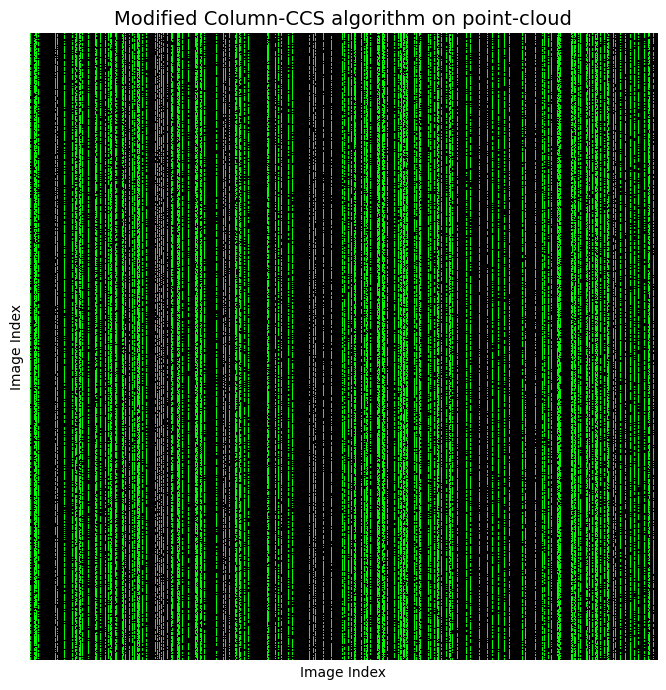

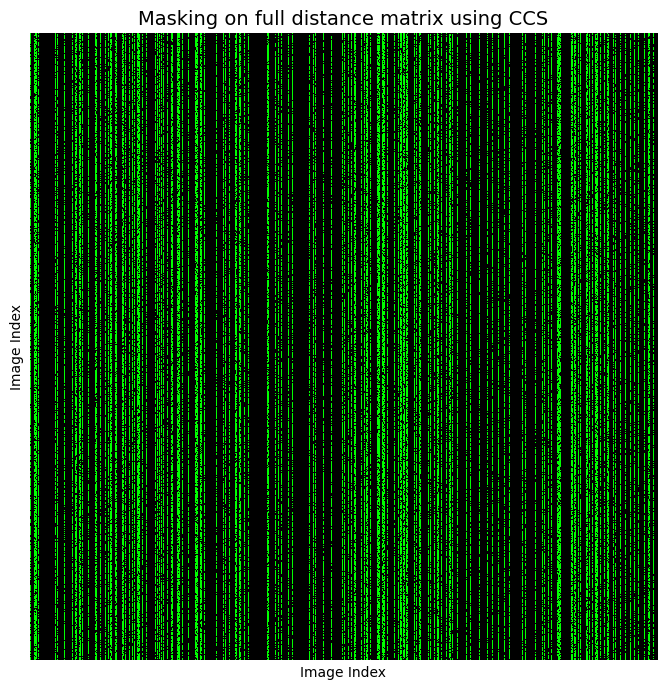

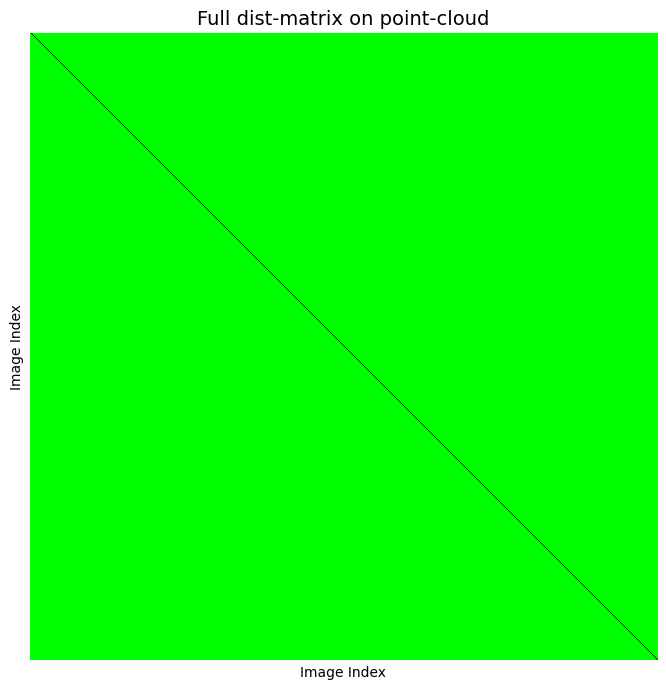

In [92]:
visualize_distance_matrix(X_Omega_ccs, title="Modified Column-CCS algorithm on point-cloud")
visualize_distance_matrix(X_Omega_ccs_og, title="Masking on full distance matrix using CCS")
visualize_distance_matrix(full_dist_matrix, title="Full dist-matrix on point-cloud")

In [138]:
params_ICURC = {
        'eta': [1 / params_CCS['p'], 1 / params_CCS['p'], 1 / (2 * params_CCS['p'])],
        'TOL': 1e-4,
        'max_ite': 500
}
r = 4
# Test updated ICURC with column only
C, U_pinv, ICURC_time = ICURC(X_Omega_ccs, J_ccs, r, params_ICURC)
Mout_CURf = C @ U_pinv @ C.T
np.fill_diagonal(Mout_CURf, 0) #

# Compute SNR
ccs_snr = compute_snr_db(full_dist_matrix, Mout_CURf)
print(f" SNR (in db) : {ccs_snr:.4f}; Total recovery time - {ICURC_time:.4f} seconds")

ICURC finished in 500 iterations, final error: 6.45e-02, total runtime: 6.22s
 SNR (in db) : 22.9973; Total recovery time - 6.2222 seconds


In [139]:
Mout_CURf

array([[ 0.        , 14.90704294,  5.05472276, ...,  3.98937402,
         9.77158474,  6.84817324],
       [14.90704294,  0.        , 10.43184939, ..., 13.21032599,
        10.17595946, 14.65195963],
       [ 5.05472276, 10.43184939,  0.        , ...,  3.3862289 ,
         5.32946108,  4.74210626],
       ...,
       [ 3.98937402, 13.21032599,  3.3862289 , ...,  0.        ,
        10.07885581,  4.20561575],
       [ 9.77158474, 10.17595946,  5.32946108, ..., 10.07885581,
         0.        , 11.57749126],
       [ 6.84817324, 14.65195963,  4.74210626, ...,  4.20561575,
        11.57749126,  0.        ]])

In [140]:
full_dist_matrix

array([[ 0.        , 14.17077718,  4.94177652, ...,  4.05208159,
         9.42930635,  6.67153537],
       [14.17077718,  0.        , 11.04657075, ..., 14.94577397,
        10.60510085, 17.40094873],
       [ 4.94177652, 11.04657075,  0.        , ...,  3.0706054 ,
         5.43095471,  3.44924319],
       ...,
       [ 4.05208159, 14.94577397,  3.0706054 , ...,  0.        ,
        10.04992295,  3.93132296],
       [ 9.42930635, 10.60510085,  5.43095471, ..., 10.04992295,
         0.        , 11.38611032],
       [ 6.67153537, 17.40094873,  3.44924319, ...,  3.93132296,
        11.38611032,  0.        ]])

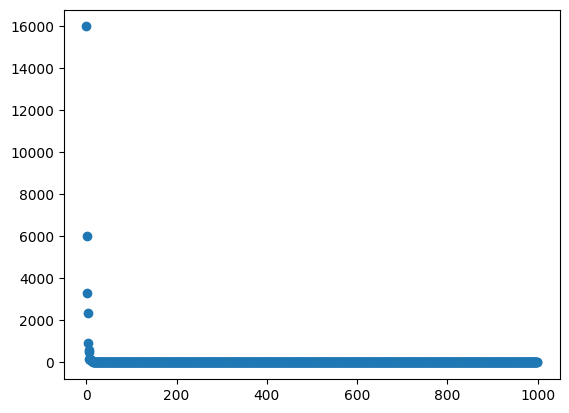

In [90]:
U, S, VT = np.linalg.svd(full_dist_matrix)
plt.scatter(range(S.shape[0]), S)

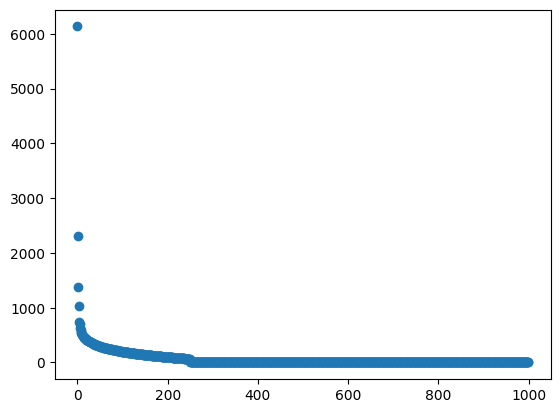

In [91]:
U, S, VT = np.linalg.svd(X_Omega_ccs)
plt.scatter(range(S.shape[0]), S)

#### Original CCS masking

In [88]:
# Run for all instances in the point_clouds
X_Omega_ccs_og, J_ccs_og, sampled_positions_og, C_Obs_og = CCS(full_dist_matrix, params_CCS, rng=67)

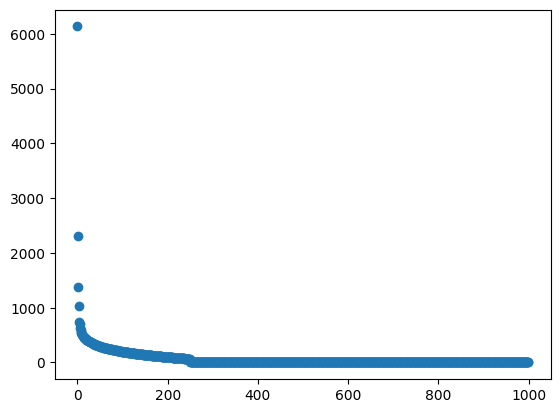

In [89]:
U, S, VT = np.linalg.svd(X_Omega_ccs_og)
plt.scatter(range(S.shape[0]), S)

In [102]:
r = 4
n = 1000

(r*(2*n-r))

7984

#### Tests for Rank vs SNR after matrix completion

In [93]:
# Define target percentages
#fra_targets = np.arange(5,100,5) # 5% to 95%
#fra_targets = np.arange(10,32,2) # 10, 12, 14... 30%
fra_targets = np.arange(10,75,5)

# generate possible p and d values between 0 and 1
p_values = np.linspace(0.05, 1.0, 10)
#d_values = np.linspace(0.05, 1.0, 20)
d_values = np.arange(0.1,0.75,0.05)

# Store different rank values
ranks = [4,6,8,10,15,20]

# Store results
results = {}
for fra in fra_targets:
    target = fra / 100  # convert to fraction
    pairs = []
    for p in p_values:
        for d in d_values:
            if abs(p * d - target) < 0.01 and 0 < d < 1:
                pairs.append((round(p, 2), round(d, 2)))
    results[fra] = pairs
# Convert into a DataFrame
rows = []
for fra, pairs in results.items():
    for p, d in pairs:
        rows.append({"SamplePercentage": fra, "p": p, "delta": d})

df = pd.DataFrame(rows, columns=["p", "delta", "SamplePercentage"])
#unique_df = df.drop_duplicates(subset="Sample_Percentage", keep="first").reset_index(drop=True)
#unique_df = df.groupby("Sample_Percentage", as_index=False)[["p", "delta"]].median()
unique_df = df.groupby("SamplePercentage", as_index=False).apply(lambda x: x.sample(1)).reset_index(drop=True)
#unique_df

In [104]:
import warnings
warnings.filterwarnings('ignore')

ranks = [4,6,8,10,15,20]       # Store different rank values
results = []                   # list to store results
rank_df = pd.DataFrame()

# Running the test
start = time.perf_counter()
for rank in ranks:
    snr_df = comapare_CCS_SNR(full_dist_matrix, unique_df.copy(), method=1, r=rank)
    snr_df["Rank"] = rank               
    results.append(snr_df)      # store the df

rank_df = pd.concat(results, ignore_index=False)
end = time.perf_counter()
print(f"Total test run-time: {(end - start)/60:.2f} mins")

Total test run-time: 6.77 mins


In [107]:
rank_df.head()

,p,delta,SamplePercentage,SNR,RecoveryTime(secs),CCS_Sample%,Rank
0,0.16,0.70,10,-1830.9091,6.95,11.19,4
1,0.79,0.20,15,22.8427,0.77,15.78,4
2,1.00,0.20,20,23.0854,0.81,19.98,4
3,0.47,0.55,25,23.0099,5.16,25.82,4
4,1.00,0.30,30,22.9856,1.68,29.97,4


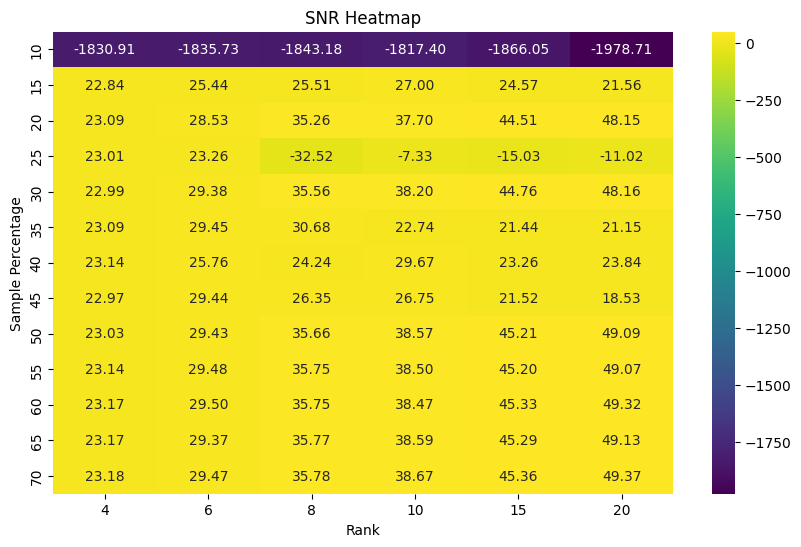

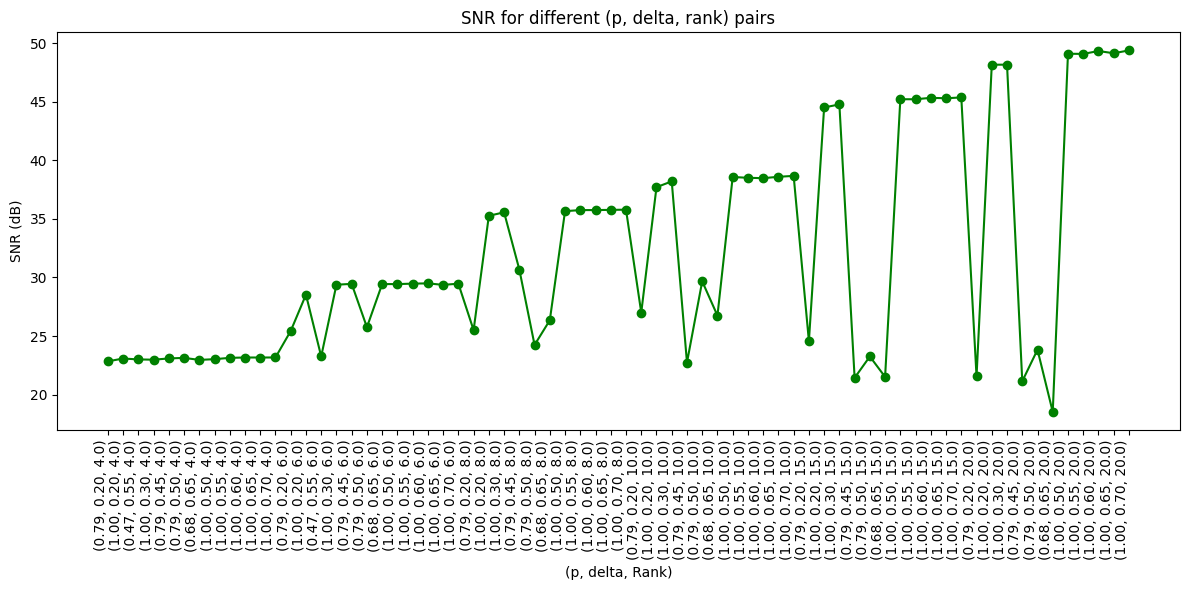

In [157]:
import seaborn as sns
rank_snr_heatmap(rank_df, rounded_frac=True)
rank_snr_lineplot(rank_df)

#### Testing on all possible values of p and delta

Plot only the highest SNR row

In [105]:
# For all possible values of p and delta
import warnings
warnings.filterwarnings('ignore')

ranks = [4,6,8,10,15,20]       # Store different rank values
results = []                   # list to store results
rank_df_full = pd.DataFrame()

# Running the test
start = time.perf_counter()
for rank in ranks:
    snr_df = comapare_CCS_SNR(full_dist_matrix, df.copy(), method=1, r=rank)
    snr_df["Rank"] = rank               
    results.append(snr_df)      # store the df

rank_df_full = pd.concat(results, ignore_index=False)
end = time.perf_counter()
print(f"Total test run-time: {(end - start)/60:.2f} mins")

Total test run-time: 19.18 mins


In [156]:
rank_df_full.describe().T

,count,mean,std,min,25%,50%,75%,max
p,276.0,0.676304,0.283552,0.1600,0.470000,0.6800,1.000000,1.0000
delta,276.0,0.447826,0.173506,0.1000,0.300000,0.4500,0.600000,0.7000
SamplePercentage,276.0,29.021739,16.633577,10.0000,15.000000,25.0000,40.000000,70.0000
SNR,276.0,-266.441673,610.813818,-2060.2353,-22.525725,23.0974,29.456125,49.3807
RecoveryTime(secs),276.0,3.922210,2.504997,0.2300,1.567500,3.6650,5.995000,8.7400
CCS_Sample%,276.0,29.001993,16.592240,9.0900,14.490000,25.8500,40.010000,69.9300
Rank,276.0,10.500000,5.479549,4.0000,6.000000,9.0000,15.000000,20.0000


In [134]:
nonzero_snr_df = rank_df_full[rank_df_full["SNR"]>0].reset_index(drop=True)

In [142]:
# Sort by SNR in descending order so the best SNR comes first
df_sorted = nonzero_snr_df.sort_values(by='SNR', ascending=False)

# Now drop duplicates; this keeps the row with the highest SNR for each Rank/Sample% pair
df_filtered = df_sorted.drop_duplicates(subset=['Rank', 'SamplePercentage'])

In [143]:
df_filtered

,p,delta,SamplePercentage,SNR,RecoveryTime(secs),CCS_Sample%,Rank
197,1.00,0.70,70,49.3807,8.56,69.93,20
194,1.00,0.55,55,49.3110,5.24,54.95,20
195,1.00,0.60,60,49.2307,6.30,59.94,20
192,1.00,0.50,50,49.1976,4.30,49.95,20
196,1.00,0.65,65,49.0996,7.47,64.94,20
...,...,...,...,...,...,...,...
13,1.00,0.20,20,23.1074,0.79,19.98,4
18,0.68,0.45,30,23.0975,3.69,30.57,4
14,0.37,0.70,25,23.0402,8.22,25.87,4
5,0.47,0.30,15,22.9077,1.56,14.09,4


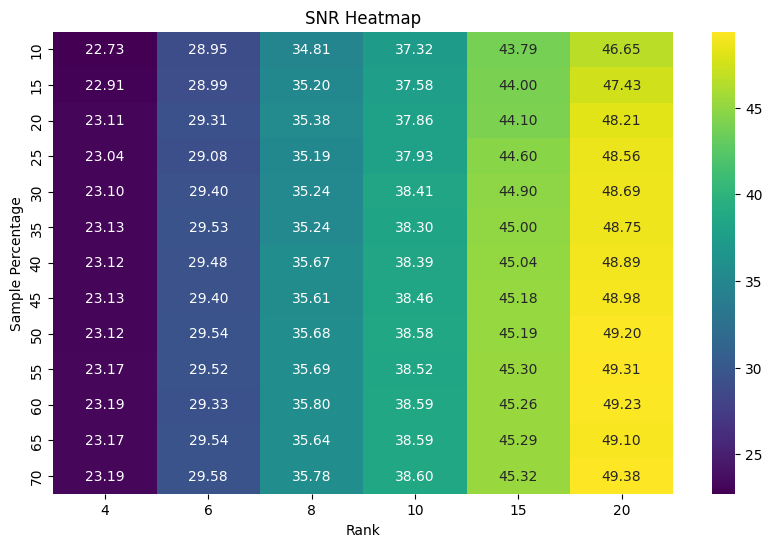

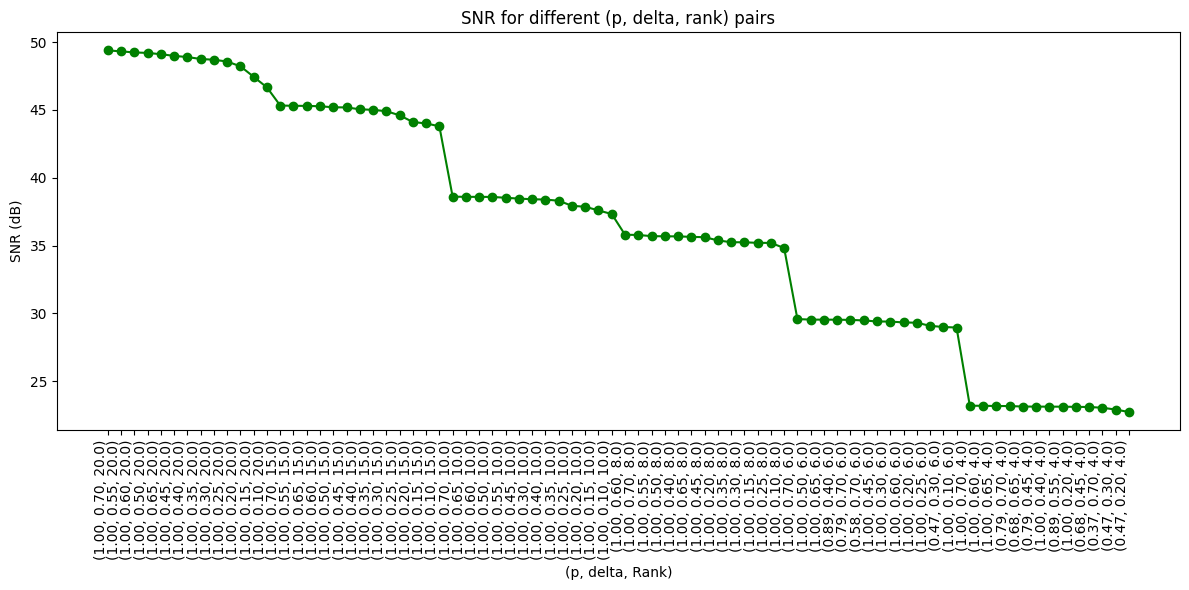

In [152]:
rank_snr_heatmap(df_filtered, rounded_frac=True)
rank_snr_lineplot(df_filtered)

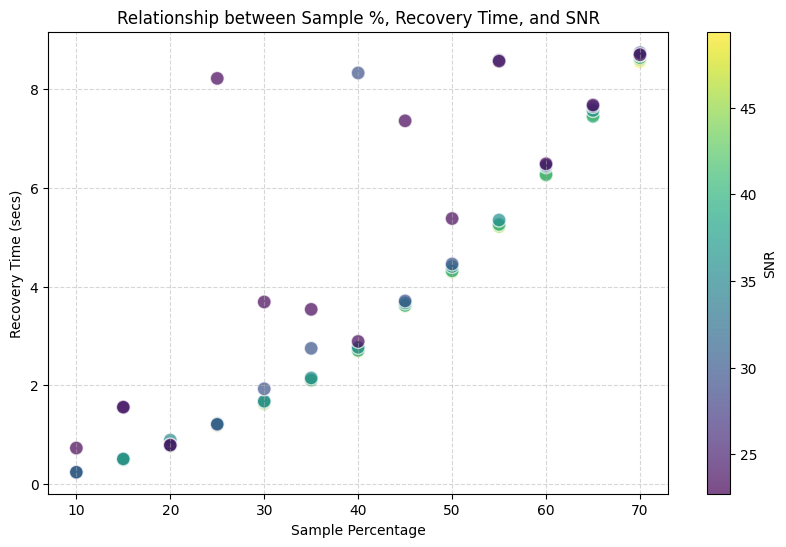

In [154]:
# Create a scatter plot
plt.figure(figsize=(10, 6))

# Plot: x=SamplePercentage, y=RecoveryTime, color=SNR
scatter = plt.scatter(
    df_filtered['SamplePercentage'], 
    df_filtered['RecoveryTime(secs)'], 
    c=df_filtered['SNR'],          # Color mapping variable
    cmap='viridis',       # Color scheme
    s=100,                # Size of dots
    alpha=0.7,            # Transparency
    edgecolors='w'        # White border around dots
)

# Add labels and title
plt.title('Relationship between Sample %, Recovery Time, and SNR')
plt.xlabel('Sample Percentage')
plt.ylabel('Recovery Time (secs)')

# Add a colorbar to represent SNR
cbar = plt.colorbar(scatter)
cbar.set_label('SNR')

# Add grid for readability
plt.grid(True, linestyle='--', alpha=0.5)

In [155]:
nonzero_snr_df.describe().T

,count,mean,std,min,25%,50%,75%,max
p,198.0,0.821313,0.180690,0.3700,0.680000,0.89000,1.000000,1.0000
delta,198.0,0.423990,0.174861,0.1000,0.250000,0.45000,0.550000,0.7000
SamplePercentage,198.0,34.595960,16.139883,10.0000,20.000000,35.00000,45.000000,70.0000
SNR,198.0,28.976286,8.863091,6.1987,22.979425,25.56085,35.195175,49.3807
RecoveryTime(secs),198.0,3.692222,2.568563,0.2300,1.235000,3.55000,5.345000,8.7400
CCS_Sample%,198.0,34.541717,16.073839,9.2400,20.280000,34.97000,44.460000,69.9300
Rank,198.0,10.156566,5.493950,4.0000,6.000000,8.00000,15.000000,20.0000
